In [187]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import h5py
sys.path.append('../')
import analysis_utils as utils

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()
from scipy.signal import savgol_filter

In [28]:
from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator

In [29]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py'>

In [30]:
file = '/Users/yuhan/work/nanospheres/data/dm_data_processed/sphere_20250103/sphere_20250103_recon_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['recon_data_all']
    hist = g['hist'][:]
    n_window = g['hist'].attrs['n_windows']
    scaling = g['hist'].attrs['scaling']

    rate_all = g['rate_hist'][:]
    rate_all_err = g['rate_hist_err'][:]
    bc = g['bc'][:]

    time_all = g.attrs['time_hours']

    fout.close()

file = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed/sphere_20250103_calibration_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['calibration_data_processed']
    eff_coefs = g['sig_efficiency_fit_params'][:]

    fout.close()

In [31]:
from scipy.special import erf
def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

In [282]:
def expo_corrected(x, b, xi, eff_coefs=None):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 50000)

    if eff_coefs is not None:
        eff_xx = func2(xx, *eff_coefs)
        expo_eff_truncated = eff_xx * np.exp(-1 * (xx) / xi) / xi
    else:
        expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < b] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    if eff_coefs is not None:
        eff_x = func2(x, *eff_coefs)
        ret = eff_x * np.exp(-1 * (x) / xi) / xi
    else:
        ret = np.exp(-1 * (x) / xi) / xi
    ret[x < b] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm

def half_gaus_mod(x, mu, m, n):
    xx = np.linspace(0, 50000, 50000)
    sigma = m * xx + n
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    sigma_x = m * x + n
    return (1 / (np.sqrt(2 * np.pi) * sigma_x)) * np.exp(-1 * (x - mu)**2 / (2 * sigma_x**2)) / _norm

def half_gaus_mod_fixed(x, mu, sigma):
    xx = np.linspace(0, 50000, 50000)
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2)) / _norm

In [283]:
def nll(alpha, mu, m, n, b, xi, bc, hist, eff_coefs=None):
    idx = bc > 800

    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = alpha * half_gaus_mod(bi, mu, m, n) + (1 - alpha) * expo_corrected(bi, b, xi, eff_coefs=None)
    mui = ntot * joint_pdf * 50


    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [287]:
from scipy.optimize import minimize

ntot = np.sum(hist)
args = (bc, hist, None)
res = minimize(fun=lambda x: nll(*x, *args), x0=[0.999999068, 378, 5.6e-2, 142, 1414, 140],
               method='Nelder-Mead',
               bounds=[(0.99, 1), (0, 500), (0, 0.1), (100, 300), (1000, 1500), (90, 160)],
               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.0001,
                        }
               )

# res = minimize(fun=lambda x: nll(*x, *args), x0=[0.999999, 200, 5e-2, 180, 1400, 120],
#                method='COBYQA',
#                bounds=[(0.99, 1), (0, 500), (0, 0.1), (100, 300), (1000, 1600), (90, 160)],
#                tol=1e-6,
#                options={'disp' : True,
#                         'maxiter': 10000,
#                         'maxfev': 10000,
#                         'scale': True,
#                         }
#                )

param_nodm = res.x
nll_nodm   = res.fun

Optimization terminated successfully.
         Current function value: -4304827608.245811
         Iterations: 1217
         Function evaluations: 2127


In [37]:
res.x

array([9.99999411e-01, 3.63789735e+02, 5.82216279e-02, 1.41641008e+02,
       1.47480619e+03, 1.23523645e+02])

In [35]:
def hist_fit_likelihood(bcs, ntot, alpha, mu, m, n, b, xi):
    return ntot * 50 * (alpha * half_gaus_mod(bcs, mu, m, n) + (1 - alpha) * expo_corrected(bcs, b, xi, eff_coefs))

def plot_likelihood_fit(bc, hist, res_x):
    fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])

    ntot = np.sum(hist)
    alpha, mu, m, n, b, xi = res_x

    idx = bc > 800
    hist_norm = n_window * scaling

    hist_fit_ml = hist_fit_likelihood(bc[idx], np.sum(hist), *res_x)

    ax = axes[0]
    ax.fill_betweenx(np.logspace(-1, 9, 100), 0, 800, color='#B0C4DE', alpha=0.5)
    ax.errorbar(bc[idx], hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)

    ax.plot(bc[idx], hist_fit_ml, '--', color='#DC143C', label='Gaussian + exponential (ML)')

    xx2 = np.linspace(820, 10000, 500)
    gaus_hist = ntot * 50 * alpha * half_gaus_mod(xx2, mu, m, n)
    ax.fill_between(xx2, 0, gaus_hist, color='#E1BE6A', alpha=0.25)

    xx1 = np.linspace(b, 10000, 500)
    expo_hist = ntot * 50 * (1 - alpha) * expo_corrected(xx1, b, xi, eff_coefs=None)
    ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

    ax.set_yscale('log')

    ax.set_xlim(0, 6000)
    ax.set_ylim(1e-1, 1e9)

    ax.set_yticks(np.logspace(-1, 9, 11))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.legend(frameon=False)
    ax.set_xticklabels([''])
    ax.set_ylabel('Counts / (50 keV/c)')

    ax = axes[1]
    ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')
    ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, 800, color='#B0C4DE', alpha=0.5)

    ax.set_xlim(0, 6000)
    ax.set_ylim(-150, 150)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.set_xlabel('Reconstructed amplitude (keV/c)')
    ax.set_ylabel('Residual / $\sigma_{\mathrm{stat}}$')

    fig.suptitle('Sphere 20250103')
    fig.tight_layout()

    return fig, axes

<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_3520/3987666047.py:52: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Residual / $\sigma_{\mathrm{stat}}$')


/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_3520/3987666047.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_3520/3987666047.py:45: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


(<Figure size 700x800 with 2 Axes>,
 array([<Axes: ylabel='Counts / (50 keV/c)'>,
        <Axes: xlabel='Reconstructed amplitude (keV/c)', ylabel='Residual / $\\sigma_{\\mathrm{stat}}$'>],
       dtype=object))

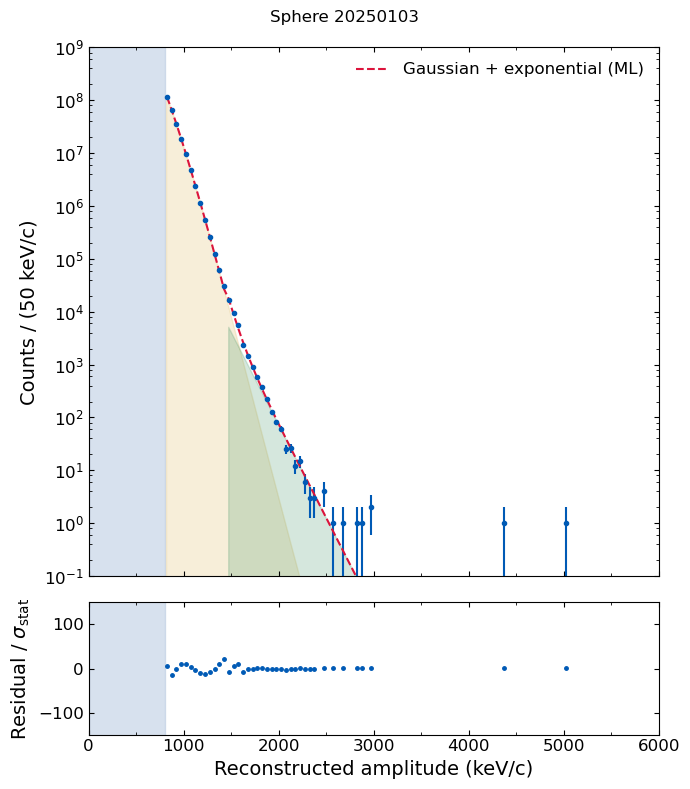

In [289]:
plot_likelihood_fit(bc, hist, res.x)

In [80]:
R_um       = 0.083
mphi = 1

mx_list    = np.logspace(-2, 5, 40)
alpha_list = np.logspace(-10, -4, 40)

mx_list_1    = np.logspace(0, 1, 10)
alpha_list_1 = np.logspace(-7, -3, 20)


In [314]:
lim_1ev_0 = get_alpha_limits(1, 0)
lim_1ev_1 = get_alpha_limits(1, 1)

nan_0 = np.isnan(lim_1ev_0[1])
nan_1 = np.isnan(lim_1ev_1[1])
mx_all = np.concatenate([lim_1ev_0[0][~nan_0], lim_1ev_1[0][~nan_1]])
alpha_upper_all = np.concatenate([lim_1ev_0[1][~nan_0], lim_1ev_1[1][~nan_1]])

mx_all_sorted, idx_sorted = np.unique(mx_all, return_index=True)
alpha_upper_all_sorted = alpha_upper_all[idx_sorted]

# idx_notnan = np.logical_not(np.isnan(alpha_upper_all_sorted))

In [341]:
def smooth_nlls(alpha_list, nlls):
    _res, _alpha = nlls, alpha_list

    for i, nll in enumerate(_res):
        if i == 0:
            continue
        if nll < _res[i-1]:
            if i == (_res.size - 1):
                _res[i] = _res[i - 1]
            else:
                _res[i] = np.interp(_alpha[i], [_alpha[i-1], _alpha[i+1]], [_res[i-1], _res[i+1]])

    return _res

def get_upper_alpha(alpha_list, nlls):
    _nlls = nlls[~np.isnan(nlls)]
    _alpha = alpha_list[~np.isnan(nlls)]

    if _nlls.size == 0:
        return np.nan
    
    # Remove spikes in the nlls using a median filter
    _nlls = medfilt(_nlls, 3)
    idx_ml = np.argmin(_nlls)

    # if np.max(_nlls - _nlls[idx_ml]) < 5:
    #     return np.nan

    # Make sure NLLs are strictly increasing above the
    # maximum likelihood alpha
    idx_search = _alpha >= _alpha[idx_ml]
    if np.sum(idx_search) == 0:
        return np.nan

    delta_nlls_smoothed = smooth_nlls(_alpha[idx_search], _nlls[idx_search] - _nlls[idx_ml])

    return np.exp(np.interp(3.841, 2*delta_nlls_smoothed, np.log(_alpha[idx_search]), left=np.nan, right=np.nan))


def get_alpha_limits(mphi, list_idx=0):
    nlls_file = np.load(fr'/Users/yuhan/work/nanospheres/impulse_analysis/profile_nlls/profile_nlls_{mphi:.0e}_{list_idx}.npz')
    nlls = nlls_file['nll']
    mx_list, alpha_list = nlls_file['mx'], nlls_file['alpha']

    alpha_upper = np.empty(mx_list.size)
    for i in range(mx_list.size):
        alpha_upper[i] = get_upper_alpha(alpha_list, nlls[i])

    return mx_list, alpha_upper, alpha_list, nlls


In [361]:
lim_10ev_0 = get_alpha_limits(10, 0)
lim_1ev_0 = get_alpha_limits(1, 0)
lim_0_1ev_0 = get_alpha_limits(0.1, 0)
lim_0_01ev_0 = get_alpha_limits(0.01, 0)
lim_0_01ev_2 = get_alpha_limits(0.01, 2)

In [345]:
lim_0_01ev_0[0]

array([1.00000000e-02, 1.51177507e-02, 2.28546386e-02, 3.45510729e-02,
       5.22334507e-02, 7.89652287e-02, 1.19377664e-01, 1.80472177e-01,
       2.72833338e-01, 4.12462638e-01, 6.23550734e-01, 9.42668455e-01,
       1.42510267e+00, 2.15443469e+00, 3.25702066e+00, 4.92388263e+00,
       7.44380301e+00, 1.12533558e+01, 1.70125428e+01, 2.57191381e+01,
       3.88815518e+01, 5.87801607e+01, 8.88623816e+01, 1.34339933e+02,
       2.03091762e+02, 3.07029063e+02, 4.64158883e+02, 7.01703829e+02,
       1.06081836e+03, 1.60371874e+03, 2.42446202e+03, 3.66524124e+03,
       5.54102033e+03, 8.37677640e+03, 1.26638017e+04, 1.91448198e+04,
       2.89426612e+04, 4.37547938e+04, 6.61474064e+04, 1.00000000e+05])

In [352]:
lim_0_01ev_0[1]

array([2.04262484e-06, 5.90434565e-05, 5.37228133e-05, 7.30695847e-05,
       7.84261632e-06, 7.50606581e-05,            nan, 8.29557937e-05,
                  nan, 3.75185563e-05,            nan, 1.30215551e-05,
       3.71202439e-05, 8.24813283e-05,            nan, 9.72847823e-08,
       2.56329846e-07, 1.87531770e-07, 3.70355877e-07, 3.72008265e-07,
       7.38264950e-07, 5.58118940e-07, 1.10788671e-06, 1.33621229e-06,
       1.02190620e-06, 3.35088059e-06, 4.54203464e-06, 6.35818356e-06,
       8.54089221e-06, 1.56465171e-05, 1.84626349e-05, 5.27834885e-05,
       8.41527054e-05,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan])

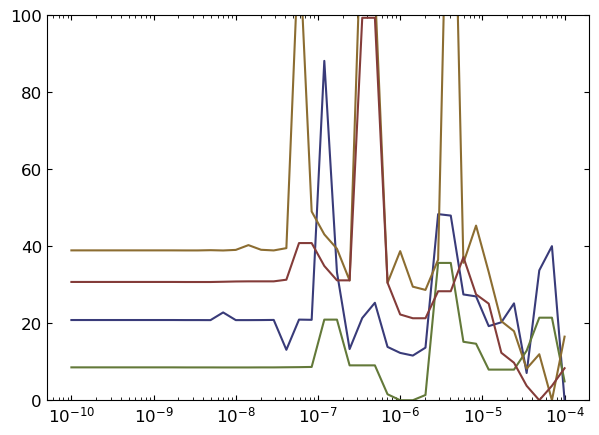

In [344]:
alpha = lim_0_01ev_0[-2]

for i in range(0, 2):
    nll = lim_0_01ev_0[-1][i]
    filtered = medfilt(nll, 3)

    plt.plot(alpha, nll - np.min(nll), '-')
    plt.plot(alpha, filtered - np.min(filtered), '-')

plt.ylim(0, 100)
plt.xscale('log')


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_3520/3402291931.py:1: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(lim_10ev_0[0], lim_10ev_0[1], label='$m_\phi$ = 10 eV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_3520/3402291931.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mx_all_sorted, alpha_upper_all_sorted, label='$m_\phi$ = 1 eV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_3520/3402291931.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(lim_0_1ev_0[0], lim_0_1ev_0[1], label='$m_\phi$ = 0.1 eV')
/var/folders/

Text(0, 0.5, '95% CL Upper limit on $\\alpha_n$')

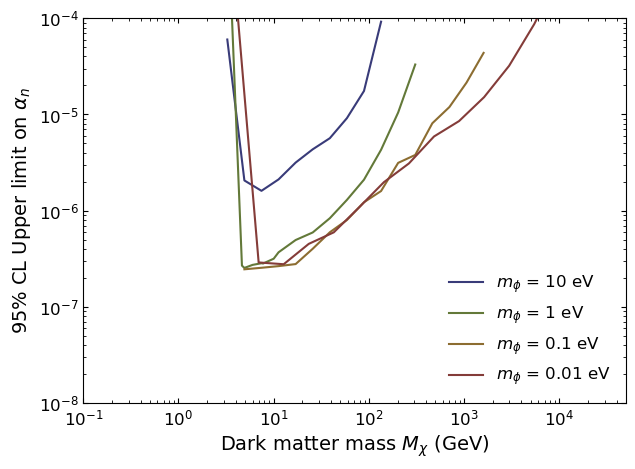

In [363]:
plt.plot(lim_10ev_0[0], lim_10ev_0[1], label='$m_\phi$ = 10 eV')
# plt.plot(lim_1ev_0[0], lim_1ev_0[1], label='$m_\phi$ = 1 eV')
plt.plot(mx_all_sorted, alpha_upper_all_sorted, label='$m_\phi$ = 1 eV')
plt.plot(lim_0_1ev_0[0], lim_0_1ev_0[1], label='$m_\phi$ = 0.1 eV')
# plt.plot(lim_0_01ev_0[0], lim_0_01ev_0[1], label='$m_\phi$ = 0.01 eV')
plt.plot(lim_0_01ev_2[0], lim_0_01ev_2[1], label='$m_\phi$ = 0.01 eV')



plt.xlim(1e-1, 5e4)
plt.ylim(1e-8, 1e-4)

plt.yscale('log')
plt.xscale('log')

plt.legend(frameon=False)
plt.xlabel(r'Dark matter mass $M_\chi$ (GeV)')
plt.ylabel(r'95% CL Upper limit on $\alpha_n$')

In [360]:
np.log10(np.logspace(-1, 4, 39))

array([-1.        , -0.86842105, -0.73684211, -0.60526316, -0.47368421,
       -0.34210526, -0.21052632, -0.07894737,  0.05263158,  0.18421053,
        0.31578947,  0.44736842,  0.57894737,  0.71052632,  0.84210526,
        0.97368421,  1.10526316,  1.23684211,  1.36842105,  1.5       ,
        1.63157895,  1.76315789,  1.89473684,  2.02631579,  2.15789474,
        2.28947368,  2.42105263,  2.55263158,  2.68421053,  2.81578947,
        2.94736842,  3.07894737,  3.21052632,  3.34210526,  3.47368421,
        3.60526316,  3.73684211,  3.86842105,  4.        ])

In [359]:
np.log10(np.logspace(-1, 4, 20))

array([-1.        , -0.73684211, -0.47368421, -0.21052632,  0.05263158,
        0.31578947,  0.57894737,  0.84210526,  1.10526316,  1.36842105,
        1.63157895,  1.89473684,  2.15789474,  2.42105263,  2.68421053,
        2.94736842,  3.21052632,  3.47368421,  3.73684211,  4.        ])

In [356]:
mx_list_0_01ev

array([1.00000000e-02, 1.51177507e-02, 2.28546386e-02, 3.45510729e-02,
       5.22334507e-02, 7.89652287e-02, 1.19377664e-01, 1.80472177e-01,
       2.72833338e-01, 4.12462638e-01, 6.23550734e-01, 9.42668455e-01,
       1.42510267e+00, 2.15443469e+00, 3.25702066e+00, 4.92388263e+00,
       7.44380301e+00, 1.12533558e+01, 1.70125428e+01, 2.57191381e+01,
       3.88815518e+01, 5.87801607e+01, 8.88623816e+01, 1.34339933e+02,
       2.03091762e+02, 3.07029063e+02, 4.64158883e+02, 7.01703829e+02,
       1.06081836e+03, 1.60371874e+03, 2.42446202e+03, 3.66524124e+03,
       5.54102033e+03, 8.37677640e+03, 1.26638017e+04, 1.91448198e+04,
       2.89426612e+04, 4.37547938e+04, 6.61474064e+04, 1.00000000e+05])

In [510]:
alpha_upper_0_1ev

array([8.70355842e-06, 1.71471869e-05, 3.74724048e-05, 7.47798971e-05,
                  nan, 2.00811055e-08,            nan,            nan,
                  nan, 4.54746906e-06,            nan,            nan,
                  nan, 3.40891633e-05, 7.91690766e-05,            nan,
       1.87255998e-07,            nan, 1.00000000e-04,            nan,
       5.94607463e-07, 7.04264646e-07, 1.08367395e-06, 1.34828300e-06,
       2.99601785e-06, 3.77667357e-06, 7.62426979e-06, 1.12897364e-06,
       2.15185643e-05, 4.19224107e-05,            nan,            nan,
                  nan,            nan,            nan,            nan,
       2.59142891e-05,            nan, 7.09174840e-05,            nan])